# Exemple de Neural ODEs avec PyTorch Lightning et TorchDyn

Nous avons commencé par un exemple simple d'utilisation de PyTorch avec les réseaux de neurones utilisant des EDOs.

Cet exemple consiste en un problème de classification binaire. Le data set est constitué de points (x,y) sur des cercles imbriqués dans le plan ainsi que de leur label indiqué par couleur.

![dataset](dataset.png)

Nous aimerions créer un réseau qui classifie des points dans le plan, sachant que les points sur le cercle extérieurs sont classés dans la classe 0, et que les points sur le cercle intérieur sont classés dans la classe 1.

Pour cela, on va créer un neural ODE en utilisant un LightningModule pour une tâche de classification. Le forward sera fait via une instance de la classe NeuralDe. Pour créer une instance de NeuralDE, il faut donner comme input un réseau de neurones.

In [61]:
import torch.nn as nn
import pytorch_lightning as pl
from torchdyn.models import *

class LitNeuralODE(pl.LightningModule):
    def __init__(self, f:nn.Module, sensitivity="adjoint", solver="dopri5"):
        super().__init__()
        self.model = NeuralDE(f, sensitivity=sensitivity, solver=solver)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch   
        self.model.nfe=0
        xS = self(x)
        loss = nn.CrossEntropyLoss()(xS, y)
        logs = {'loss', loss, 'nfe', self.model.nfe}
        self.log('nfe', self.model.nfe, prog_bar=True)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-6)

    def train_dataloader(self):
        return trainloader

Maintenant que nous avons crée le modèle, nous pouvons l'entrainer sur un ensemble de points:

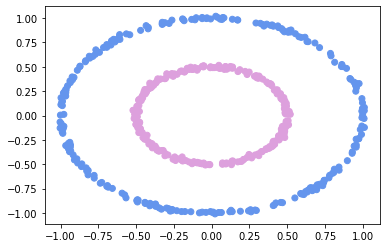

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 226   
-----------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] /home/fmsd/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s, loss=0.000369, v_num=6, nfe=44.00]


In [62]:
import torch ; import torch.utils.data as data
from torchdyn.datasets import *
import torch.nn as nn
from torchdyn.models import *
import matplotlib.pyplot as plt
from litneuralode import *

def show_data(X, y):
    data = X.detach().numpy().tolist()
    couleur = []
    for i in range(len(data)):
        if y[i] > 0:
            couleur.append('plum')
        else:
            couleur.append('cornflowerblue')
    plt.scatter([i[0] for i in data],[i[1] for i in data],  color = couleur)
    plt.show()

def show_evolution(X, y):
    colors = ['cornflowerblue', 'plum']
    # compute trajectories of the trained model
    s_span = torch.linspace(0, 1, 10) ; 
    xS = nde.model.trajectory(X.to(device), s_span).detach().cpu()

    # plot resulting state-space trajectories
    fig, ax = plt.subplots(figsize=(5, 5))
    for i in range(512):
        plt.plot(xS[:,i,0], xS[:,i,1], color=colors[int(y[i])], alpha=.3);
    plt.scatter(xS[-1,:,0], xS[-1,:,1], color='black', alpha=.3);
    plt.show()

if __name__ == "__main__":
    X, y = ToyDataset().generate(n_samples=512, noise=1e-2, dataset_type='spheres', dim=2)  
    show_data(X, y)

    X_test, y_test = ToyDataset().generate(n_samples=256, noise=1e-2, dataset_type='spheres', dim=2)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    train = data.TensorDataset(X.to(device), y.long().to(device))
    trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

    f = nn.Sequential(DataControl(), nn.Linear(4, 32), nn.Tanh(), nn.Linear(32, 2))
    nde = LitNeuralODE(f).to(device)
    trainer = pl.Trainer(max_epochs=1000, auto_select_gpus=True, progress_bar_refresh_rate=1)
    trainer.fit(nde, trainloader)



Erreur pour le test set:  0.0


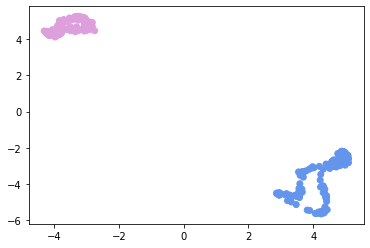

In [63]:
from torch import tensor
from sklearn.metrics import log_loss

def show_data_1(X, y):
    couleur = []
    for i in range(len(X)):
        if y[i] > 0:
            couleur.append('plum')
        else:
            couleur.append('cornflowerblue')
    plt.scatter([i[0] for i in X],[i[1] for i in X],  color = couleur)
    plt.show()

pred = nde(X_test)
pred = pred.detach().numpy()
loss = log_loss(y_test, pred)
print("Erreur pour le test set: ", loss)
show_data_1(pred, y_test)

On peut visualiser l'évolution du training via la fonction trajectory du modèle crée.

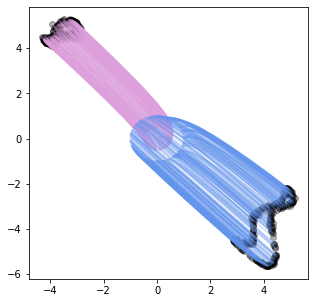

In [64]:
show_evolution(X,y)

Maintenant que nous avons un modèle entrainé pour classer des points, nous pouvons les tester sur de nouveaux points des cercles créés aléatoirement.

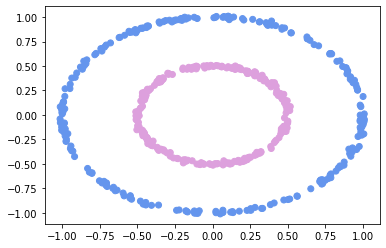

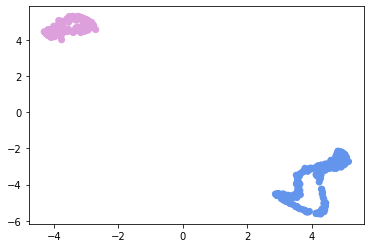

In [65]:
X_test, y_test = ToyDataset().generate(n_samples=512, noise=1e-2, dataset_type='spheres', dim=2)

show_data(X_test, y_test)

X_pred = nde(X_test)

show_data(X_pred, y_test)

On peut aussi tester le modèle sur des points qui ne sont pas sur les cercles.

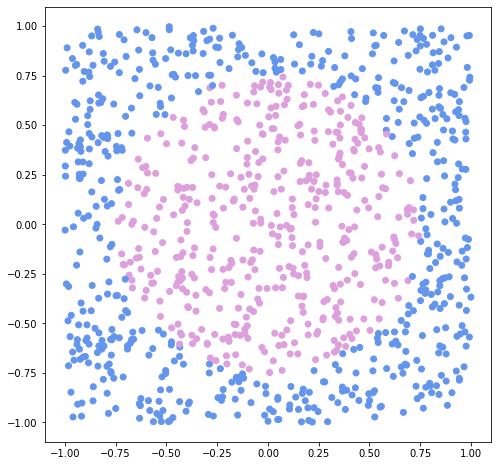

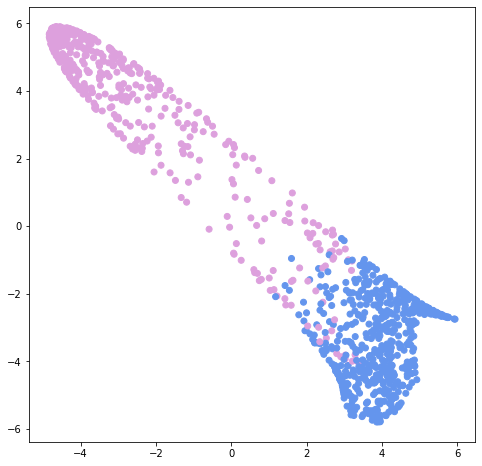

In [66]:
import numpy as np

def colors(data):
    colors = []
    for point in data:
        if np.linalg.norm(point) > 0.75:
            colors.append('cornflowerblue')
        else:
            colors.append('plum')
    return colors

X_test = np.random.rand(1000,2) * 2 - np.ones((1000,2))
data_test = X_test.tolist()
colors = colors(data_test)
fig = plt.figure(1, figsize=(8,8))
plt.scatter([i[0] for i in data_test],[i[1] for i in data_test], c = colors)
plt.show()

Xs_pred = nde(torch.tensor(X_test, dtype=torch.float))
data = Xs_pred.detach().numpy().tolist()
fig = plt.figure(1, figsize=(8,8))
plt.scatter([i[0] for i in data],[i[1] for i in data], c = colors)
plt.show()